In [1]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, BartModel, BartForSequenceClassification, Trainer, TrainingArguments
import accelerate

import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment

import os
import pandas as pd
import matplotlib.pyplot as plt

/home/nyx/clustering-vs-classification/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
assert torch.cuda.is_available()
device = torch.device("cuda")

# Data pre-processing

In [3]:
df = pd.read_csv("data/bone_tumor.csv")
df = df.sample(frac=1)
df.head()

,Patient ID,Sex,Age,Grade,Histological type,MSKCC type,Site of primary STS,"Status (NED, AWD, D)",Treatment
268,STS_269,Female,49,Intermediate,synovial sarcoma,Synovial sarcoma,right thigh,NED,Radiotherapy + Surgery
422,STS_423,Male,72,High,poorly differentiated synovial sarcoma,Leiomyosarcoma,right parascapusular,AWD,Radiotherapy + Surgery + Chemotherapy
106,STS_107,Female,72,Intermediate,leiomyosarcoma,Synovial sarcoma,parascapusular,NED,Radiotherapy + Surgery
355,STS_356,Female,41,High,pleomorphic sarcoma,Synovial sarcoma,right thigh,NED,Radiotherapy + Surgery
11,STS_012,Male,44,High,pleiomorphic spindle cell undifferentiated,MFH,right thigh,NED,Radiotherapy + Surgery + Chemotherapy


In [4]:

splits = [0.9, 0.05, 0.05]
train_len, eval_len, test_len = [int(len(df) * k) for k in splits]

train_stats_df = df[:train_len]
eval_stats_df = df[train_len : train_len + eval_len]
test_stats_df = df[train_len + eval_len : ]

In [5]:
train_stats_df.head()

,Patient ID,Sex,Age,Grade,Histological type,MSKCC type,Site of primary STS,"Status (NED, AWD, D)",Treatment
268,STS_269,Female,49,Intermediate,synovial sarcoma,Synovial sarcoma,right thigh,NED,Radiotherapy + Surgery
422,STS_423,Male,72,High,poorly differentiated synovial sarcoma,Leiomyosarcoma,right parascapusular,AWD,Radiotherapy + Surgery + Chemotherapy
106,STS_107,Female,72,Intermediate,leiomyosarcoma,Synovial sarcoma,parascapusular,NED,Radiotherapy + Surgery
355,STS_356,Female,41,High,pleomorphic sarcoma,Synovial sarcoma,right thigh,NED,Radiotherapy + Surgery
11,STS_012,Male,44,High,pleiomorphic spindle cell undifferentiated,MFH,right thigh,NED,Radiotherapy + Surgery + Chemotherapy


In [6]:
eval_stats_df.head()

,Patient ID,Sex,Age,Grade,Histological type,MSKCC type,Site of primary STS,"Status (NED, AWD, D)",Treatment
16,STS_017,Female,80,Intermediate,synovial sarcoma,Leiomyosarcoma,right thigh,NED,Radiotherapy + Surgery
127,STS_128,Female,59,Intermediate,undifferentiated - pleiomorphic,MFH,right thigh,NED,Radiotherapy + Surgery
202,STS_203,Female,24,Intermediate,epithelioid sarcoma,Synovial sarcoma,right thigh,D,Radiotherapy + Surgery
300,STS_301,Female,76,Intermediate,leiomyosarcoma,Synovial sarcoma,right thigh,NED,Radiotherapy + Surgery
53,STS_054,Male,52,High,pleiomorphic leiomyosarcoma,MFH,parascapusular,D,Radiotherapy + Surgery


In [7]:
test_stats_df.head()

,Patient ID,Sex,Age,Grade,Histological type,MSKCC type,Site of primary STS,"Status (NED, AWD, D)",Treatment
169,STS_170,Female,58,High,pleomorphic sarcoma,MFH,left thigh,AWD,Radiotherapy + Surgery + Chemotherapy
21,STS_022,Female,66,High,myxofibrosarcoma,MFH,right parascapusular,AWD,Radiotherapy + Surgery + Chemotherapy
69,STS_070,Female,36,Intermediate,synovial sarcoma,Leiomyosarcoma,right thigh,NED,Radiotherapy + Surgery
43,STS_044,Female,53,Intermediate,pleiomorphic leiomyosarcoma,Leiomyosarcoma,right thigh,NED,Radiotherapy + Surgery
6,STS_007,Female,38,Intermediate,pleiomorphic leiomyosarcoma,MFH,left biceps,NED,Radiotherapy + Surgery


In [8]:
def grade_description(grade: str) -> str:
    grade = grade.lower()
    assert grade in ["high", "intermediate", "low"]

    if grade == "high":
        return "The tumor is fast-growing and more likely to spread"
    elif grade == "intermediate":
        return "The tumor is of medium growth rate and has an average risk of spreading"
    else:
        return "The tumor is slow-growing and less likely to spread"

In [9]:
def status_description(status: str) -> str:
    status = status.upper()
    assert status in ["NED", "AWD", "D"]

    if status == "NED":
        return "The patient is cancer-free.", 0
    elif status == "AWD":
        return "The patient has cancer but is not showing any signs of disease progression.", 1
    else:
        return "The patient has died from cancer.", 2

In [10]:
def treatment_description(treatment: str) -> str:
    lst = treatment.split(" + ")
    res = ", ".join(lst[:len(lst) - 1])
    res += f" and {lst[-1]}"
    return res.lower()

In [11]:
def construct_dataset(df):
    data = []

    for i, row in df.iterrows():
        sex = row["Sex"].lower()
        age = row["Age"]
        grade = grade_description(row["Grade"])
        histological_type = row["Histological type"] # type of tumor
        mskcc_type = row["MSKCC type"] # more specific classification of the tumor
        site_of_primary_sts = row["Site of primary STS"] # location of the tumor in the bone
        treatment = treatment_description(row["Treatment"])
        
        # used as the label (y)
        status, label = status_description(row["Status (NED, AWD, D)"])

        story = f"This patient is a {age}-year-old {sex}. The patient has a tumor of histological type {histological_type} and MSKCC type {mskcc_type} on their {site_of_primary_sts}. {grade}. The patient has received the following treatment: {treatment}."

        data.append({"story": story, "status": status, "label": label})
    
    return pd.DataFrame(data)

In [12]:
train_df = construct_dataset(train_stats_df)
eval_df = construct_dataset(eval_stats_df)
test_df = construct_dataset(test_stats_df)

In [13]:
train_df.head()

,story,status,label
0,This patient is a 49-year-old female. The pati...,The patient is cancer-free.,0
1,This patient is a 72-year-old male. The patien...,The patient has cancer but is not showing any ...,1
2,This patient is a 72-year-old female. The pati...,The patient is cancer-free.,0
3,This patient is a 41-year-old female. The pati...,The patient is cancer-free.,0
4,This patient is a 44-year-old male. The patien...,The patient is cancer-free.,0


In [14]:
eval_df.head()

,story,status,label
0,This patient is a 80-year-old female. The pati...,The patient is cancer-free.,0
1,This patient is a 59-year-old female. The pati...,The patient is cancer-free.,0
2,This patient is a 24-year-old female. The pati...,The patient has died from cancer.,2
3,This patient is a 76-year-old female. The pati...,The patient is cancer-free.,0
4,This patient is a 52-year-old male. The patien...,The patient has died from cancer.,2


In [15]:
test_df.head()

,story,status,label
0,This patient is a 58-year-old female. The pati...,The patient has cancer but is not showing any ...,1
1,This patient is a 66-year-old female. The pati...,The patient has cancer but is not showing any ...,1
2,This patient is a 36-year-old female. The pati...,The patient is cancer-free.,0
3,This patient is a 53-year-old female. The pati...,The patient is cancer-free.,0
4,This patient is a 38-year-old female. The pati...,The patient is cancer-free.,0


# BART

## Classification

In [16]:
tokenizer = AutoTokenizer.from_pretrained(
    "facebook/bart-large",
)
tokenizer.padding_side = "right"

model = BartForSequenceClassification.from_pretrained("facebook/bart-large", num_labels=3).to(device)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Sanity check
Calculate accuracy with base model

In [17]:
predictions = []
actuals = []

for i, row in test_df.iterrows():
    inputs = tokenizer(row["story"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    
    with torch.no_grad():  # Don't compute gradients during inference
        prediction = model(**inputs.to(device))
    
    predicted_label = torch.argmax(prediction.logits, dim=-1).item()
    
    predictions.append(predicted_label)
    actuals.append(row["label"])

In [18]:
print(f"Accuracy: {accuracy_score(actuals, predictions)}")
print(classification_report(actuals, predictions))

Accuracy: 0.16
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.16      1.00      0.28         4
           2       0.00      0.00      0.00         8

    accuracy                           0.16        25
   macro avg       0.05      0.33      0.09        25
weighted avg       0.03      0.16      0.04        25



/home/nyx/clustering-vs-classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nyx/clustering-vs-classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nyx/clustering-vs-classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

### Training

In [19]:
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [20]:
def encode_data(tokenizer, text, labels):
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
    inputs["labels"] = torch.tensor(labels)
    return inputs

In [21]:
def compute_metrics(eval_pred):
    logits = eval_pred.predictions[0]
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, predictions, average="weighted")}

In [22]:
def train_model(train_dataset, eval_dataset):
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=20,
        per_device_train_batch_size=10,
        per_device_eval_batch_size=10,
        warmup_steps=5,
        weight_decay=0.01,
        eval_strategy="steps",
        eval_steps=5,
        save_strategy="best",
        metric_for_best_model="f1",
        greater_is_better=True,
        dataloader_pin_memory=False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    return trainer

In [23]:
train_dataset = TextDataset(encode_data(tokenizer, train_df["story"].tolist(), train_df["label"].tolist()))
eval_dataset = TextDataset(encode_data(tokenizer, eval_df["story"].tolist(), eval_df["label"].tolist()))

In [24]:
trainer = train_model(train_dataset, eval_dataset)

/tmp/ipykernel_670877/1527015662.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/nyx/clustering-vs-classification/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,F1
5,No log,0.989920,0.155152
10,No log,0.843108,0.457000
15,No log,0.741107,0.547232
20,No log,0.842946,0.572323
25,No log,0.820995,0.546667
30,No log,0.642307,0.641548
35,No log,0.689039,0.612789
40,No log,0.558109,0.698692
45,No log,0.681307,0.606111
50,No log,0.604660,0.698692


/home/nyx/clustering-vs-classification/.venv/lib/python3.13/site-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/tmp/ipykernel_670877/1527015662.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/nyx/clustering-vs-classification/.venv/lib/python3.13/

In [25]:
best_checkpoint = sorted(os.listdir("results"), key=lambda x: int(x.split("-")[1]))[-1]
best_checkpoint = f"results/{best_checkpoint}"

In [26]:
ft_model = BartForSequenceClassification.from_pretrained(best_checkpoint, num_labels=3).to(device)

In [27]:
predictions = []
actuals = []

for i, row in test_df.iterrows():
    inputs = tokenizer(row["story"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    
    with torch.no_grad():
        prediction = ft_model(**inputs.to(device))
    
    predicted_label = torch.argmax(prediction.logits, dim=-1).item()
    
    predictions.append(predicted_label)
    actuals.append(row["label"])

In [28]:
print(f"Accuracy: {accuracy_score(actuals, predictions)}")
print(classification_report(actuals, predictions))

Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.67      1.00      0.80         4
           2       0.83      0.62      0.71         8

    accuracy                           0.80        25
   macro avg       0.78      0.82      0.79        25
weighted avg       0.81      0.80      0.80        25



In [29]:
predictions

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 0, 2, 0]

In [30]:
actuals

[1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 1, 1, 0, 2, 0, 2, 2]

## Clustering
We are using the weights of the finetuned model from the previous part and clustering last hidden states with k-means clustering.

In [31]:
clustering_model = BartModel.from_pretrained(best_checkpoint, num_labels=3).to(device)

In [32]:
hidden_states_list = []

for i, row in test_df.iterrows():
    inputs = tokenizer(row["story"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    with torch.no_grad():
        prediction = clustering_model(**inputs.to(device))

    last_hidden = prediction.last_hidden_state.mean(dim=1) # average pooling
    hidden_states_list.append(last_hidden.cpu().numpy())

hidden_states_array = np.vstack(hidden_states_list)

In [33]:
kmeans = KMeans(n_clusters=3, random_state=67)
cluster_labels = kmeans.fit_predict(hidden_states_array)

### Visualizing embeddings with t-SNE

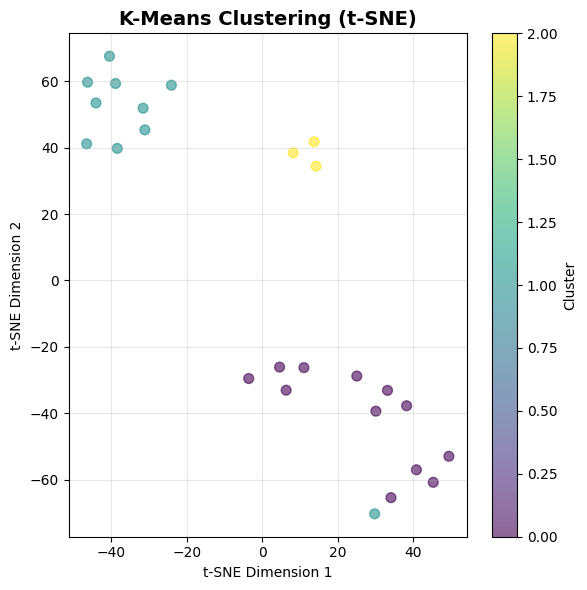

In [34]:
tsne = TSNE(n_components=2, random_state=67, perplexity=5.0)
tsne_embeddings = tsne.fit_transform(hidden_states_array)

fig, axes = plt.subplots(1, 1, figsize=(6, 6))

scatter2 = axes.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50)
axes.set_title('K-Means Clustering (t-SNE)', fontsize=14, fontweight='bold')
axes.set_xlabel('t-SNE Dimension 1')
axes.set_ylabel('t-SNE Dimension 2')
axes.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes, label='Cluster')

plt.tight_layout()
plt.show()

### Hungarian Algorithm
Mapping cluster label indices (which are arbitrary) to meaningful indices that correspond to the labels in the dataset

In [35]:
true_labels = test_df["label"].values
cluster_labels_array = cluster_labels
conf_matrix = confusion_matrix(true_labels, cluster_labels_array)

In [36]:

row_idx, col_idx = linear_sum_assignment(-conf_matrix)
mapping = {col_idx[i]: row_idx[i] for i in range(len(row_idx))}

mapping

{np.int64(1): np.int64(0), np.int64(0): np.int64(1), np.int64(2): np.int64(2)}

In [37]:
clustering_df = pd.DataFrame()
clustering_df["golden"] = test_df["label"]
clustering_df["mapped_cluster"] = np.array([mapping[c] for c in cluster_labels_array])

In [38]:
print(f"Accuracy: {accuracy_score(clustering_df["golden"].to_list(), clustering_df["mapped_cluster"].to_list())}")
print(classification_report(clustering_df["golden"].to_list(), clustering_df["mapped_cluster"].to_list()))

Accuracy: 0.64
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.33      1.00      0.50         4
           2       0.67      0.25      0.36         8

    accuracy                           0.64        25
   macro avg       0.67      0.67      0.58        25
weighted avg       0.79      0.64      0.65        25

